# Connect to Google Drive

In [354]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Perkenalan

Nama: Bagus Tirta Aji Hakim

Batch: RMT 018

Dataset: Cencusl Adult Income `bigquery-public-data.ml_datasets.census_adult_income`

Objective: Memprediksi `income_bracket`

Field Name  | Description
------------- | -------------
`age`  | Age
`workclass`  | Nature of employment
`education`  | Level of education completed
`education_num`  | Estimated years of education completed based on the value of the education field.
`marital_status`  | Marital status
`occupation`  | Occupation category
`relationship`  | Relationship to the household
`race`  | Race
`sex`  | Gender
`capital_gain`  | Amount of capital gains
`capital_loss`  | Amount of capital loss
`hours_per_week`  | Hours worked per week
`native_country`  | Country of birth
`income_bracket`  | Either ">50K" or "<=50K" based on income.

# Sql Query

```
select age,
       workclass, 
       education, 
       education_num, 
       marital_status, 
       occupation, 
       relationship, 
       race, 
       sex, 
       capital_gain, 
       capital_loss,
       hours_per_week, 
       native_country, 
       income_bracket
from bigquery-public-data.ml_datasets.census_adult_income
where workclass not like '%?%' 
     and occupation not like '%?%' 
     and native_country not like '%?%' 
     and hours_per_week < 100
limit 36000;
```

# Import Libraries

In [355]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


# Check library version

In [356]:
# sklearn.__version__

In [357]:
# pandas.__version__

# Data Loading

In [358]:
df = pd.read_csv('/content/drive/MyDrive/Hacktiv8/GC_dataset/h8dsft_P1G2_BagusTirtaAji.csv')

In [359]:
# melakukan copy data untuk backup

data = df.copy()

In [360]:
df.head(10)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,77,Private,9th,5,Married-civ-spouse,Priv-house-serv,Wife,Black,Female,0,0,10,United-States,<=50K
2,38,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,24,Haiti,<=50K
3,28,Private,9th,5,Married-civ-spouse,Protective-serv,Wife,Black,Female,0,0,40,United-States,<=50K
4,37,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,0,0,48,United-States,<=50K
5,45,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,United-States,>50K
6,55,Private,9th,5,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,23,United-States,<=50K
7,27,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,37,Portugal,<=50K
8,31,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
9,30,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,Portugal,<=50K


In [361]:
df.tail(10)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
30152,23,Private,Some-college,10,Never-married,Adm-clerical,Other-relative,Asian-Pac-Islander,Female,0,0,24,Vietnam,<=50K
30153,22,Private,Some-college,10,Never-married,Tech-support,Other-relative,Asian-Pac-Islander,Female,0,0,32,United-States,<=50K
30154,25,Private,Some-college,10,Never-married,Craft-repair,Other-relative,Asian-Pac-Islander,Female,0,0,40,Cambodia,<=50K
30155,22,Private,Some-college,10,Never-married,Craft-repair,Other-relative,Asian-Pac-Islander,Female,0,0,40,Vietnam,<=50K
30156,48,Private,Some-college,10,Married-civ-spouse,Craft-repair,Other-relative,Asian-Pac-Islander,Male,0,0,40,Cambodia,>50K
30157,46,Private,Some-college,10,Married-civ-spouse,Craft-repair,Other-relative,Asian-Pac-Islander,Male,0,0,40,India,<=50K
30158,45,Private,Some-college,10,Married-civ-spouse,Craft-repair,Other-relative,Asian-Pac-Islander,Male,0,0,40,Philippines,<=50K
30159,32,Private,Some-college,10,Married-civ-spouse,Sales,Other-relative,Asian-Pac-Islander,Female,0,0,40,Greece,<=50K
30160,30,Self-emp-not-inc,Some-college,10,Never-married,Sales,Other-relative,Asian-Pac-Islander,Male,0,2258,40,South,<=50K
30161,20,Self-emp-not-inc,Some-college,10,Never-married,Prof-specialty,Other-relative,Asian-Pac-Islander,Female,0,0,20,South,<=50K


In [362]:
# mengecek apakah terdapat unique value yang duplikat maupun ekstra spasi

df['workclass'].unique()

array([' Private', ' Local-gov', ' Self-emp-inc', ' Federal-gov',
       ' State-gov', ' Self-emp-not-inc', ' Without-pay'], dtype=object)

In [363]:
# menghapus semua space kosong di tiap value pada variabel

df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Eploratory Data Analysis (EDA)

In [364]:
df.shape

(30162, 14)

In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   education       30162 non-null  object
 3   education_num   30162 non-null  int64 
 4   marital_status  30162 non-null  object
 5   occupation      30162 non-null  object
 6   relationship    30162 non-null  object
 7   race            30162 non-null  object
 8   sex             30162 non-null  object
 9   capital_gain    30162 non-null  int64 
 10  capital_loss    30162 non-null  int64 
 11  hours_per_week  30162 non-null  int64 
 12  native_country  30162 non-null  object
 13  income_bracket  30162 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.2+ MB


In [366]:
df.describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,10.121312,1092.007858,88.372489,40.931238
std,13.134665,2.549995,7406.346497,404.298370,11.979984
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


## Numeric and Categoric Data Analysis 

In [367]:
df_numeric = df.select_dtypes(include=[np.number])
df_categoric = df.select_dtypes(include=['object'])

In [368]:
df_numeric

,age,education_num,capital_gain,capital_loss,hours_per_week
0,39,5,3411,0,34
1,77,5,0,0,10
2,38,5,0,0,24
3,28,5,0,0,40
4,37,5,0,0,48
...,...,...,...,...,...
30157,46,10,0,0,40
30158,45,10,0,0,40
30159,32,10,0,0,40
30160,30,10,0,2258,40


In [369]:
df_numeric['education_num'].value_counts().reset_index().sort_values(by=['index'], ascending=True)

,index,education_num
15,1,45
14,2,151
13,3,288
8,4,557
10,5,455
7,6,820
5,7,1048
11,8,377
0,9,9840
1,10,6678


In [370]:
df_categoric

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income_bracket
0,Private,9th,Married-civ-spouse,Other-service,Wife,Black,Female,United-States,<=50K
1,Private,9th,Married-civ-spouse,Priv-house-serv,Wife,Black,Female,United-States,<=50K
2,Private,9th,Married-civ-spouse,Other-service,Wife,Black,Female,Haiti,<=50K
3,Private,9th,Married-civ-spouse,Protective-serv,Wife,Black,Female,United-States,<=50K
4,Private,9th,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,United-States,<=50K
...,...,...,...,...,...,...,...,...,...
30157,Private,Some-college,Married-civ-spouse,Craft-repair,Other-relative,Asian-Pac-Islander,Male,India,<=50K
30158,Private,Some-college,Married-civ-spouse,Craft-repair,Other-relative,Asian-Pac-Islander,Male,Philippines,<=50K
30159,Private,Some-college,Married-civ-spouse,Sales,Other-relative,Asian-Pac-Islander,Female,Greece,<=50K
30160,Self-emp-not-inc,Some-college,Never-married,Sales,Other-relative,Asian-Pac-Islander,Male,South,<=50K


In [371]:
print('Total unique value =',df_categoric['workclass'].nunique())
df_categoric['workclass'].value_counts().reset_index()

Total unique value = 7


,index,workclass
0,Private,22286
1,Self-emp-not-inc,2499
2,Local-gov,2067
3,State-gov,1279
4,Self-emp-inc,1074
5,Federal-gov,943
6,Without-pay,14


jenis pekerjaan yang paling banyak adalah private

In [372]:
print('Total unique value =',df_categoric['education'].nunique())
df_categoric['education'].value_counts().reset_index().sort_values(by=['education'], ascending=False)

Total unique value = 16


,index,education
0,HS-grad,9840
1,Some-college,6678
2,Bachelors,5044
3,Masters,1627
4,Assoc-voc,1307
5,11th,1048
6,Assoc-acdm,1008
7,10th,820
8,7th-8th,557
9,Prof-school,542


Pendidikan terakhir yang paling banyak adalah HS-grad atau HighSchool graduate

In [373]:
print('Total unique value =',df_categoric['marital_status'].nunique())
df_categoric['marital_status'].value_counts().reset_index().sort_values(by=['index'], ascending=True)

Total unique value = 7


,index,marital_status
2,Divorced,4214
6,Married-AF-spouse,21
0,Married-civ-spouse,14065
5,Married-spouse-absent,370
1,Never-married,9726
3,Separated,939
4,Widowed,827


data diatas merupakan status pernikahan, dan pada data ini didominasi oleh married-civ-spouse

In [374]:
print('Total unique value =',df_categoric['occupation'].nunique())
df_categoric['occupation'].value_counts().reset_index()

Total unique value = 14


,index,occupation
0,Prof-specialty,4038
1,Craft-repair,4030
2,Exec-managerial,3992
3,Adm-clerical,3721
4,Sales,3584
5,Other-service,3212
6,Machine-op-inspct,1966
7,Transport-moving,1572
8,Handlers-cleaners,1350
9,Farming-fishing,989


pekerjaan yang paling banyak digeluti adalah sebagai spesialis/professor

In [375]:
print('Total unique value =',df_categoric['relationship'].nunique())
df_categoric['relationship'].value_counts().reset_index().sort_values(by=['index'], ascending=False)

Total unique value = 6


,index,relationship
4,Wife,1406
3,Unmarried,3212
2,Own-child,4466
5,Other-relative,889
1,Not-in-family,7726
0,Husband,12463


Data diatas adalah jenis relationship yang terdata, terdapat 6 jenis dan didominasi oleh relationship husband

In [376]:
print('Total unique value =',df_categoric['race'].nunique())
df_categoric['race'].value_counts().reset_index().sort_values(by=['index'], ascending=False)

Total unique value = 5


,index,race
0,White,25933
4,Other,231
1,Black,2817
2,Asian-Pac-Islander,895
3,Amer-Indian-Eskimo,286


dataset ini didomninasi oleh race white

In [377]:
print('Total unique value =',df_categoric['sex'].nunique())
df_categoric['sex'].value_counts().reset_index().sort_values(by=['index'], ascending=True)

Total unique value = 2


,index,sex
1,Female,9782
0,Male,20380


pada dataset ini, jenis kelamin male mendominasi dibandingkan female

In [378]:
print('Total unique value =',df_categoric['income_bracket'].nunique())
df_categoric['income_bracket'].value_counts().reset_index().sort_values(by=['index'], ascending=True)

Total unique value = 2


,index,income_bracket
0,<=50K,22654
1,>50K,7508


data yang diperoleh didominasi oleh jumlah pendapatan yang kurang dari 50K, yaitu sebanyak 22654 data

In [379]:
print('Total unique value =',df_categoric['native_country'].nunique())
df_categoric['native_country'].value_counts().reset_index().sort_values(by=['native_country'], ascending=False)

Total unique value = 41


,index,native_country
0,United-States,27504
1,Mexico,610
2,Philippines,188
3,Germany,128
4,Puerto-Rico,109
5,Canada,107
6,India,100
7,El-Salvador,100
8,Cuba,92
9,England,86


Data paling banyak berasal dari negara United States sebanyak 27504 data.

## High Cardinality

Disini kita berusaha untuk mengurangi jumlah unique values pada suatu variable yaitu `education` yang memiliki 16 unique values.

In [380]:
df_categoric['education'].value_counts()

HS-grad         9840
Some-college    6678
Bachelors       5044
Masters         1627
Assoc-voc       1307
11th            1048
Assoc-acdm      1008
10th             820
7th-8th          557
Prof-school      542
9th              455
12th             377
Doctorate        375
5th-6th          288
1st-4th          151
Preschool         45
Name: education, dtype: int64

melakukan transofrmasi data berdasarkan jenis pendidikan

In [381]:
# copy disini untuk menghindari munculnya warning "A value is trying to be set on a copy of a slice from a DataFrame"
df_categoric = df_categoric.copy()

for old_value in ['1st-4th', '5th-6th']:
    df_categoric.loc[df_categoric['education'] == old_value, 'education'] = 'Primary'

for old_value in ['7th-8th', '9th', '10th', '11th', '12th']:
    df_categoric.loc[df_categoric['education'] == old_value, 'education'] = 'Secondary'

unique values telah tereduksi, sehingga bisa melanjutkan tahap analisis.

In [382]:
df_categoric['education'].value_counts()

HS-grad         9840
Some-college    6678
Bachelors       5044
Secondary       3257
Masters         1627
Assoc-voc       1307
Assoc-acdm      1008
Prof-school      542
Primary          439
Doctorate        375
Preschool         45
Name: education, dtype: int64

In [383]:
# menggabungkan kembali dataset yang telah dipecah 

df = [df_numeric, df_categoric]
df = pd.concat(df, axis=1, join="outer")

## Visualization

<AxesSubplot:xlabel='income_bracket', ylabel='count'>

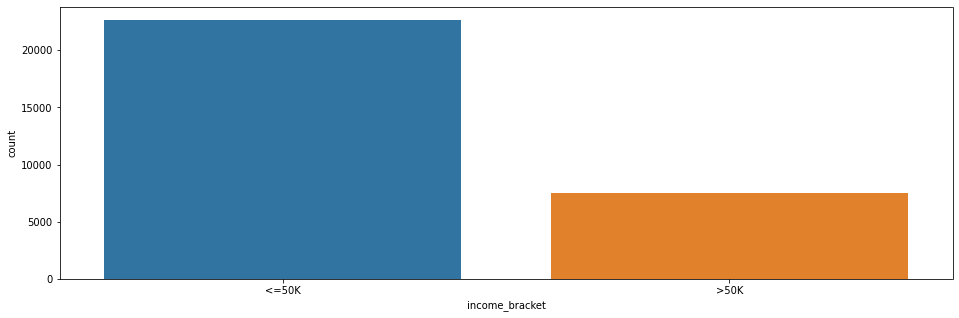

In [384]:
plt.figure(figsize=(16,5))
sns.countplot(data = df, x = 'income_bracket')

berdasarkan visualisasi, dataset didominasi oleh income yang kurang dari 50K

<AxesSubplot:xlabel='income_bracket', ylabel='count'>

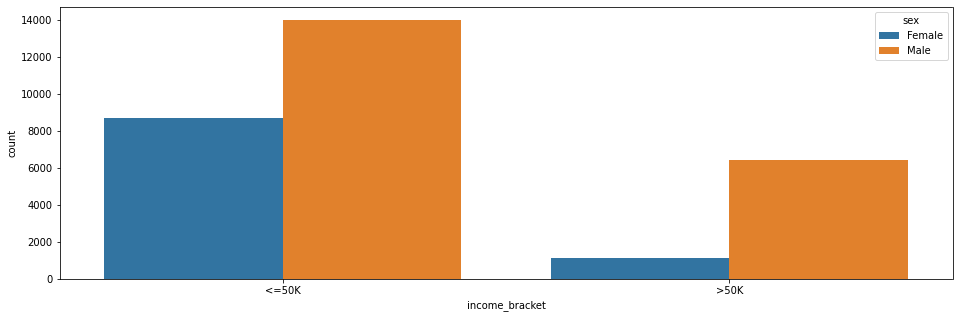

In [385]:
plt.figure(figsize=(16,5))
sns.countplot(data = df, x = 'income_bracket', hue = 'sex')

Dimana, laki-laki lebih mendominasi baik untuk income yang kurang dari 50K maupun yang lebih dari 50K. Hal ini wajar saja, berdasarkan eksplorasi yang dilakukan sebelumnya bahwasannya data kita didominasi oleh jenis kelamin laki-laki.

<AxesSubplot:xlabel='education', ylabel='count'>

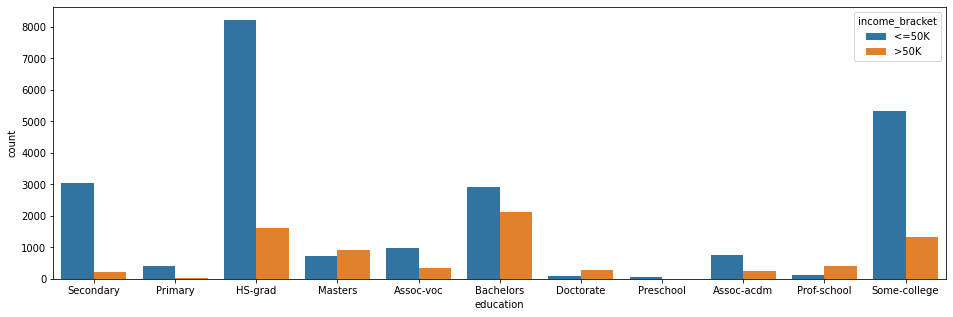

In [386]:
plt.figure(figsize=(16,5))
sns.countplot(data = df, x = 'education', hue='income_bracket')

pendapatan kurang dari 50K didominasi oleh lulusan High School, sedangkan untuk pendapatan lebih dari 50K didominasi oleh lulusan Bachelors

<AxesSubplot:xlabel='workclass', ylabel='count'>

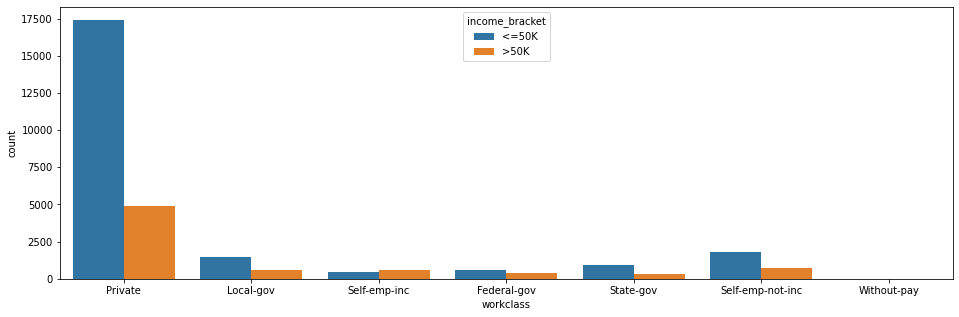

In [387]:
plt.figure(figsize=(16,5))
sns.countplot(data = df, x = 'workclass', hue='income_bracket')

kebanyakan pendapatan diperoleh oleh tipe perkejaan private dibandingkan tipe pekerjaan lainnya

# Feature Engineering

## Split between `X` (features) and `y` (target)

In [388]:
for col in df.columns:
    print(col)

age
education_num
capital_gain
capital_loss
hours_per_week
workclass
education
marital_status
occupation
relationship
race
sex
native_country
income_bracket


In [389]:
X = df.drop(columns=['income_bracket'])
y = df[['income_bracket']]

In [390]:
X

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass,education,marital_status,occupation,relationship,race,sex,native_country
0,39,5,3411,0,34,Private,Secondary,Married-civ-spouse,Other-service,Wife,Black,Female,United-States
1,77,5,0,0,10,Private,Secondary,Married-civ-spouse,Priv-house-serv,Wife,Black,Female,United-States
2,38,5,0,0,24,Private,Secondary,Married-civ-spouse,Other-service,Wife,Black,Female,Haiti
3,28,5,0,0,40,Private,Secondary,Married-civ-spouse,Protective-serv,Wife,Black,Female,United-States
4,37,5,0,0,48,Private,Secondary,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,46,10,0,0,40,Private,Some-college,Married-civ-spouse,Craft-repair,Other-relative,Asian-Pac-Islander,Male,India
30158,45,10,0,0,40,Private,Some-college,Married-civ-spouse,Craft-repair,Other-relative,Asian-Pac-Islander,Male,Philippines
30159,32,10,0,0,40,Private,Some-college,Married-civ-spouse,Sales,Other-relative,Asian-Pac-Islander,Female,Greece
30160,30,10,0,2258,40,Self-emp-not-inc,Some-college,Never-married,Sales,Other-relative,Asian-Pac-Islander,Male,South


In [391]:
y

,income_bracket
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K
...,...
30157,<=50K
30158,<=50K
30159,<=50K
30160,<=50K


## Split between Train dan Test

In [392]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train size:', X_train.shape)
print('Test size:', X_test.shape)

Train size: (24129, 13)
Test size: (6033, 13)


In [393]:
X_train

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass,education,marital_status,occupation,relationship,race,sex,native_country
18406,43,13,0,0,50,State-gov,Bachelors,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States
22563,48,12,0,0,40,Private,Assoc-acdm,Divorced,Exec-managerial,Unmarried,White,Female,England
9267,35,9,6849,0,40,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Female,United-States
23824,41,10,3137,0,40,Private,Some-college,Married-civ-spouse,Tech-support,Husband,Black,Male,United-States
12799,56,9,0,0,46,Local-gov,HS-grad,Divorced,Adm-clerical,Not-in-family,White,Female,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,22,10,0,0,40,Federal-gov,Some-college,Never-married,Adm-clerical,Not-in-family,White,Female,United-States
5390,33,9,0,0,20,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States
860,18,6,0,0,36,Private,Secondary,Never-married,Farming-fishing,Own-child,White,Male,United-States
15795,41,11,0,0,60,Self-emp-not-inc,Assoc-voc,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States


## Split Numerical and Categorical

In [394]:
num_columns = X_train.select_dtypes(include=np.number).columns.tolist()
cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()

print('Num Columns : ', num_columns)
print('Cat Columns : ', cat_columns)

Num Columns :  ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Cat Columns :  ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


In [395]:
X_train_num = X_train[num_columns]
X_test_num = X_test[num_columns]

X_train_cat = X_train[cat_columns]
X_test_cat = X_test[cat_columns]

X_train_num

,age,education_num,capital_gain,capital_loss,hours_per_week
18406,43,13,0,0,50
22563,48,12,0,0,40
9267,35,9,6849,0,40
23824,41,10,3137,0,40
12799,56,9,0,0,46
...,...,...,...,...,...
29802,22,10,0,0,40
5390,33,9,0,0,20
860,18,6,0,0,36
15795,41,11,0,0,60


In [396]:
X_train_cat

,workclass,education,marital_status,occupation,relationship,race,sex,native_country
18406,State-gov,Bachelors,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States
22563,Private,Assoc-acdm,Divorced,Exec-managerial,Unmarried,White,Female,England
9267,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Female,United-States
23824,Private,Some-college,Married-civ-spouse,Tech-support,Husband,Black,Male,United-States
12799,Local-gov,HS-grad,Divorced,Adm-clerical,Not-in-family,White,Female,United-States
...,...,...,...,...,...,...,...,...
29802,Federal-gov,Some-college,Never-married,Adm-clerical,Not-in-family,White,Female,United-States
5390,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States
860,Private,Secondary,Never-married,Farming-fishing,Own-child,White,Male,United-States
15795,Self-emp-not-inc,Assoc-voc,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States


## Check Data Distribution

In [397]:
def getDataDistribution(df, column):
    stat, p = shapiro(X_train['age'])

    # hasil uji normalitas
    alpha = 0.05
    if p > alpha:
        print("Data terdistribusi normal")
    else:
        print("Data tidak terdistribusi normal")

In [398]:
for column in X_train_num:
    print('Distirbusi data pada', column, ':')
    getDataDistribution(X_train_num, column)

Distirbusi data pada age :
Data tidak terdistribusi normal
Distirbusi data pada education_num :
Data tidak terdistribusi normal
Distirbusi data pada capital_gain :
Data tidak terdistribusi normal
Distirbusi data pada capital_loss :
Data tidak terdistribusi normal
Distirbusi data pada hours_per_week :
Data tidak terdistribusi normal


/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Outlier Handling

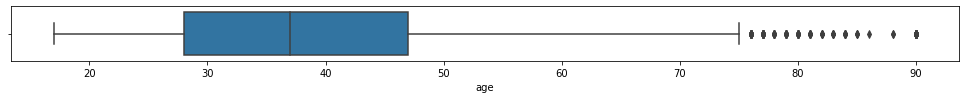

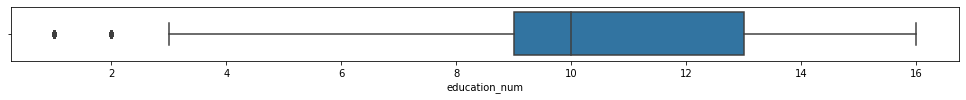

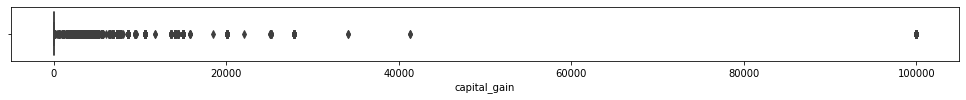

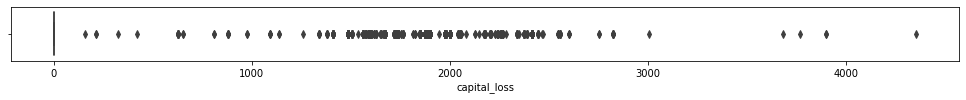

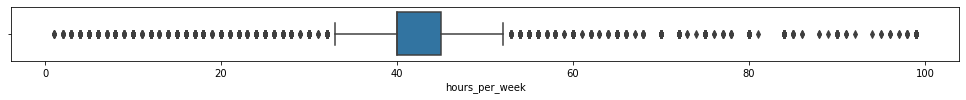

In [399]:
for column in X_train_num:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=X_train_num, x=column)

berdasarkan boxplot yang telah dibuat, outlier yang paling penting untuk dilakukan handling adalah `age`. Usia produktif biasanya berada dalam rentang 15-64 tahun. Oleh karena itu perlu dilakukan outlier handling.

Metode yang digunakan adalah interquartile range (IQR). IQR dipilih karena berdasarkan distribusi datanya adalah tidak terdistribusi normal.

In [400]:
Q1 = X_train['age'].quantile(0.25)
Q3 = X_train['age'].quantile(0.75)

IQR=Q3-Q1

X_train = X_train[~((X_train['age']<(Q1-1.5*IQR)) | (X_train['age']>(Q3+1.5*IQR)))]

In [401]:
Q1 = X_test['age'].quantile(0.25)
Q3 = X_test['age'].quantile(0.75)

IQR=Q3-Q1

X_test = X_test[~((X_test['age']<(Q1-1.5*IQR)) | (X_test['age']>(Q3+1.5*IQR)))]

## Missing Values Handling

In [402]:
X_train.isna().sum()

age               0
education_num     0
capital_gain      0
capital_loss      0
hours_per_week    0
workclass         0
education         0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
native_country    0
dtype: int64

In [403]:
X_test.isna().sum()

age               0
education_num     0
capital_gain      0
capital_loss      0
hours_per_week    0
workclass         0
education         0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
native_country    0
dtype: int64

In [404]:
y_train.isna().sum()

income_bracket    0
dtype: int64

In [405]:
y_test.isna().sum()

income_bracket    0
dtype: int64

## Feature Selection

In [406]:
X_train

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass,education,marital_status,occupation,relationship,race,sex,native_country
18406,43,13,0,0,50,State-gov,Bachelors,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States
22563,48,12,0,0,40,Private,Assoc-acdm,Divorced,Exec-managerial,Unmarried,White,Female,England
9267,35,9,6849,0,40,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Female,United-States
23824,41,10,3137,0,40,Private,Some-college,Married-civ-spouse,Tech-support,Husband,Black,Male,United-States
12799,56,9,0,0,46,Local-gov,HS-grad,Divorced,Adm-clerical,Not-in-family,White,Female,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,22,10,0,0,40,Federal-gov,Some-college,Never-married,Adm-clerical,Not-in-family,White,Female,United-States
5390,33,9,0,0,20,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States
860,18,6,0,0,36,Private,Secondary,Never-married,Farming-fishing,Own-child,White,Male,United-States
15795,41,11,0,0,60,Self-emp-not-inc,Assoc-voc,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States


Semua feature pada dataset akan digunakan sebagai feature (prediksi)

## Feature Scaling

Berdsarkan pengecekan distribusi data yang telah dilakukan sebelumnya, bahwa semua data numerik tidak terdisribusi normal, oleh karena itu feature scaling akan menggunakan MinMaxScaler()

In [407]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_num)

X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)
X_train_num_scaled

array([[0.35616438, 0.8       , 0.        , 0.        , 0.5       ],
       [0.42465753, 0.73333333, 0.        , 0.        , 0.39795918],
       [0.24657534, 0.53333333, 0.06849068, 0.        , 0.39795918],
       ...,
       [0.01369863, 0.33333333, 0.        , 0.        , 0.35714286],
       [0.32876712, 0.66666667, 0.        , 0.        , 0.60204082],
       [0.50684932, 0.6       , 0.        , 0.        , 0.39795918]])

## Feature Encoding

Encoding yang digunakan untuk data kategorik adalah One Hot Encoder, One Hot dipilih karena tipe data yang dimiliki merupakan tipe data kategorik nominal dimana tidak memperhatikan urutan.

In [408]:
oneHot_encoder = OneHotEncoder()
oneHot_encoder.fit(X_train_cat)

X_train_cat_encoded = oneHot_encoder.transform(X_train_cat).toarray()
X_test_cat_encoded = oneHot_encoder.transform(X_test_cat).toarray()
X_train_cat_encoded

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]])

## Concate Between Numerical and Categorical columns

In [409]:
X_train_final = np.concatenate([X_train_num_scaled, X_train_cat_encoded], axis=1)
X_test_final = np.concatenate([X_test_num_scaled, X_test_cat_encoded], axis=1)
X_train_final

array([[0.35616438, 0.8       , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.42465753, 0.73333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.24657534, 0.53333333, 0.06849068, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.01369863, 0.33333333, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.32876712, 0.66666667, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.50684932, 0.6       , 0.        , ..., 1.        , 0.        ,
        0.        ]])

# Modelling

## Logistic Regression

In [410]:
# Model Definition

model_LogReg = LogisticRegression()

In [411]:
# Model Training

model_LogReg.fit(X_train_final, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Evaluation: Logistic Regression with Default Parameter - Data Train

Training score: 0.8483
Test score: 0.8419 

Classification Report : 
               precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     18095
        >50K       0.74      0.61      0.67      6034

    accuracy                           0.85     24129
   macro avg       0.81      0.77      0.78     24129
weighted avg       0.84      0.85      0.84     24129

Confusion Matrix      : 


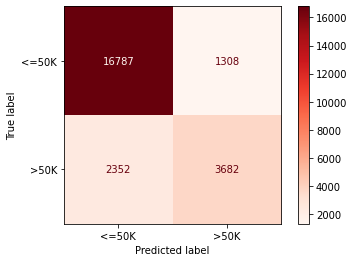

In [412]:
# Model Evaluation Logistic Regression - Data Train

y_pred_Train_LogReg = model_LogReg.predict(X_train_final)

print("Evaluation: Logistic Regression with Default Parameter - Data Train\n")
print('Training score: {:.4f}'.format(model_LogReg.score(X_train_final, y_train)))
print('Test score: {:.4f} \n'.format(model_LogReg.score(X_test_final, y_test)))
print('Classification Report : \n', classification_report(y_train,y_pred_Train_LogReg))
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(model_LogReg, X_train_final, y_train, cmap='Reds'))

Pada data train terdapat 24129 data, dimana 18095 data yang dikategorkan income `<=50K` dan 6034 data yang dikategorikan income `>50K`

**Precision pada label <50K:**
- 88% (16787) diprediksi income `<=50K` dan benar bahwa sebenarnya income `<=50K`, dan sisanya 12% (2352) salah memprediksi bahwa income `<=50K` padahal secara aktual income-nya adalah `>50K`.

**Precision pada label >50K:**
- 74% (3682) diprediksi income `>50K` dan benar bahwa sebenarnya income `>50K`, dan sisanya 26% (1308) salah memperediksi bahwa income `>50K` padahal secara aktual income-nya adalah `<=50K`

**Recall pada label <=50K:**
- sebanyak 93% (16787) yang benar terprediksi memiliki income `<=50K` dan sisanya 7% (1308) merupakan orang yang memiliki income `<=50K` namun  terprediksi sebagai orang yang memiliki income `>50K`

**Recall pada label >50K:**
- sebanyak 61% (3682) yang benar terprediksi memiliki income `>50K` dan sisanya 39% (2352) merupakan orang yang memiliki income `>50K` namun  sebagai orang yang memiliki income `<=50K`


Evaluation: Logistic Regression with Default Parameter - Data Test 

Training score: 0.8483
Test score: 0.8419 

Classification Report : 
               precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      4559
        >50K       0.71      0.59      0.65      1474

    accuracy                           0.84      6033
   macro avg       0.79      0.76      0.77      6033
weighted avg       0.84      0.84      0.84      6033

Confusion Matrix      : 


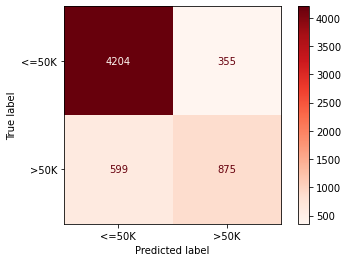

In [413]:
# Model Evaluation Logistic Regression - Data Test

y_pred_Test_LogReg = model_LogReg.predict(X_test_final)

print("Evaluation: Logistic Regression with Default Parameter - Data Test \n")
print('Training score: {:.4f}'.format(model_LogReg.score(X_train_final, y_train)))
print('Test score: {:.4f} \n'.format(model_LogReg.score(X_test_final, y_test)))
print('Classification Report : \n', classification_report(y_test,y_pred_Test_LogReg))
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(model_LogReg, X_test_final, y_test, cmap='Reds'))

Pada data test 6033 data, dimana 4559 data yang memiliki income `<=50K` dan 1474 data yang memiliki income `>50K`

**Precision pada label <50K:**
1. 88% (4204) diprediksi income `<=50K` dan benar bahwa sebenarnya income `<=50K`, dan sisanya 12% (599) salah memprediksi bahwa income `<=50K` padahal secara aktual income-nya adalah `>50K`.

**Precision pada label >50K:**
2. 71% (875) diprediksi income `>50K` dan benar bahwa sebenarnya income `>50K`, dan sisanya 29% (355) salah memperediksi bahwa income `>50K` padahal secara aktual income-nya adalah `<=50K`

**Recall pada label <=50K:**
1. sebanyak 92% (4204) yang benar terprediksi memiliki income `<=50K` dan sisanya 8% (355) merupakan orang yang memiliki income `<=50K` namun  terprediksi sebagai orang yang memiliki income `>50K`

**Recall pada label >50K:**
2. sebanyak 59% (875) yang benar terprediksi memiliki income `>50K` dan sisanya 41% (599) merupakan orang yang memiliki income `>50K` namun  sebagai orang yang memiliki income `<=50K`


## Support Vector Machine (SVM)

In [414]:
# Model Definition

model_SVC = svm.SVC()

In [415]:
# Model Training

%%time
model_SVC.fit(X_train_final, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 25 s, sys: 143 ms, total: 25.1 s
Wall time: 25.2 s


SVC()

Evaluation: Support Vector Machine Classifier with Default Parameter - Data Train 

Training score: 0.8428
Test score: 0.8326 

Classification Report : 
               precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90     18095
        >50K       0.74      0.57      0.64      6034

    accuracy                           0.84     24129
   macro avg       0.80      0.75      0.77     24129
weighted avg       0.84      0.84      0.84     24129

Confusion Matrix      : 


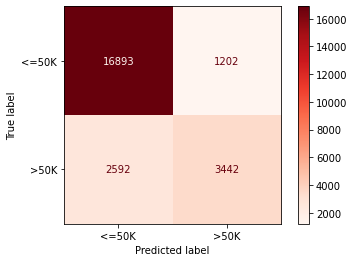

In [416]:
# Model Evaluation Support Vector Machine Classifier - Data Train

y_pred_Train_SVC = model_SVC.predict(X_train_final)

print("Evaluation: Support Vector Machine Classifier with Default Parameter - Data Train \n")
print('Training score: {:.4f}'.format(model_SVC.score(X_train_final, y_train)))
print('Test score: {:.4f} \n'.format(model_SVC.score(X_test_final, y_test)))
print('Classification Report : \n', classification_report(y_train,y_pred_Train_SVC))
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(model_SVC, X_train_final, y_train, cmap='Reds'))

sebanyak 4559 data yang memiliki income `<=50K` dan 1474 data yang memiliki income `>50K`

**Precision pada label <=50K:**
- 87% (16893) diprediksi income `<=50K` dan benar bahwa sebenarnya income `<=50K`, dan sisanya 13% (2592) salah memprediksi bahwa income `<=50K` padahal secara aktual income-nya adalah `>50K`.

**Precision pada label >50K:**
- 74% (3442) diprediksi income `>50K` dan benar bahwa sebenarnya income `>50K`, dan sisanya 26% (1202) salah memperediksi bahwa income `>50K` padahal secara aktual income-nya adalah `<=50K`

**Recall pada label <=50K:**
- sebanyak 93% (16893) yang benar terprediksi memiliki income `<=50K` dan sisanya 7% (1202) merupakan orang yang memiliki income `<=50K` namun  terprediksi sebagai orang yang memiliki income `>50K`

**Recall pada label >50K:**
- sebanyak 57% (3442) yang benar terprediksi memiliki income `>50K` dan sisanya 43% (2592) merupakan orang yang memiliki income `>50K` namun  sebagai orang yang memiliki income `<=50K`


Evaluation: Support Vector Machine Classifier with Default Parameter - Data Test 

Training score: 0.8428
Test score: 0.8326 

Classification Report : 
               precision    recall  f1-score   support

       <=50K       0.86      0.92      0.89      4559
        >50K       0.70      0.55      0.62      1474

    accuracy                           0.83      6033
   macro avg       0.78      0.74      0.76      6033
weighted avg       0.82      0.83      0.83      6033

Confusion Matrix      : 


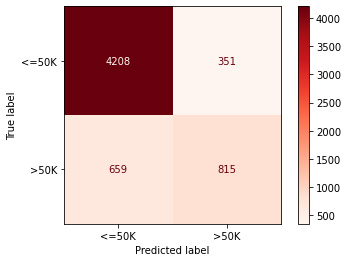

In [417]:
# Model Evaluation Support Vector Machine Classifier - Data Test

y_pred_Test_SVC = model_SVC.predict(X_test_final)

print("Evaluation: Support Vector Machine Classifier with Default Parameter - Data Test \n")
print('Training score: {:.4f}'.format(model_SVC.score(X_train_final, y_train)))
print('Test score: {:.4f} \n'.format(model_SVC.score(X_test_final, y_test)))
print('Classification Report : \n', classification_report(y_test,y_pred_Test_SVC))
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(model_SVC, X_test_final, y_test, cmap='Reds'))

sebanyak 4559 data yang memiliki income `<=50K` dan 1474 data yang memiliki income `>50K`

**Precision pada label <=50K:**
- 86% (4208) diprediksi income `<=50K` dan benar bahwa sebenarnya income `<=50K`, dan sisanya 14% (659) salah memprediksi bahwa income `<=50K` padahal secara aktual income-nya adalah `>50K`.

**Precision pada label >50K:**
- 70% (815) diprediksi income `>50K` dan benar bahwa sebenarnya income `>50K`, dan sisanya 30% (351) salah memperediksi bahwa income `>50K` padahal secara aktual income-nya adalah `<=50K`

**Recall pada label <=50K:**
- sebanyak 92% (4208) yang benar terprediksi memiliki income `<=50K` dan sisanya 8% (351) merupakan orang yang memiliki income `<=50K` namun  terprediksi sebagai orang yang memiliki income `>50K`

**Recall pada label >50K:**
- sebanyak 59% (815) yang benar terprediksi memiliki income `>50K` dan sisanya 41% (659) merupakan orang yang memiliki income `>50K` namun  sebagai orang yang memiliki income `<=50K`


# Kesimpulan

Model yang digunakan untuk analisis adalah Logistic Regression dan Support Vector Machine Classifier.

- Pada Logistic Regression terdapat hyperparameter C yang digunakan untuk membantu mengoptimalkan kinerja model untuk menghindari overfitting atau underfitting. Nilai C yang tinggi menandakan bahwa bobot terbesar terdapat pada data train dan bobot yang rendah pada penalti kesalahan klasifikasi dan sebaliknya. Dalam kata lain, jika nilai C semakin tinggi maka model sangat bergantung pada data train, jika nilai C makin rendah maka merepresentasikan bahwa data yang digunakan mungkin tidak merepresentasikan kejadian yang nyata. 

- Support Vector pada kata 'Support Vector Machine' adalah titik data yang terdekat dengan hyperplane. Sedangkan hyperplane adalah garis pembatas. Oleh karena itu SVM bekerja dengan mencari garis pembatas (hyperplane) antara titik data yang terdekat dengan hyperplane (support vector)

- Fungsi parameter kernel pada SVM untuk menentukan tipe klasifikasi yang akan digunakan, salah satu contohnya adalah kernel linear dimana data diklasifikasikan menggunakan garis linear.

**Logistic Regression**

- Training score: 0.8483
- Test score: 0.8419 

**Support Vector Machine Classifier**

- Training score: 0.8428
- Test score: 0.8326

Berdasarkan score dari kedua model tersebut, dapat dipastikan jika model yang telah dibuat tergolong goodfit. Hal itu dikarenakan nilai training score dan test score pada kedua model memiliki selisih yang sangat kecil.

**Exploratory Data Analysis**

- Dari total jumlah data sebanyak 30162, dataset didominasi oleh income yang kurang dari 50K
- laki-laki lebih mendominasi baik untuk income yang kurang dari 50K maupun yang lebih dari 50K data kita yang didominasi oleh jenis kelamin laki-laki.
- pendapatan kurang dari 50K didominasi oleh lulusan High School, sedangkan untuk pendapatan lebih dari 50K didominasi oleh lulusan Bachelors dan tipe perkejaan private.


**Kelamahan dan Kelebihan pada Model:**

- Berdasarkan precision dan recall, Logistic Regression mampu melakukan klasifikasi yang lebih baik dibandingkan dengan SVC.
- Selain itu, Logistic Regression mampu melakukan modelling lebih cepat dibandingkan dengan SVC.

**Pemilihan Model**
- Model yang digunakan untuk inference adalah Logistic Regression, hal ini dikarenakan hasil training score dan test score yang memiliki selisih jauh lebih kecil dibandingkan dengan SVC serta nilai test yang lebih tinggi pada Logistic Regression daripada SVC.

**Saran Improvement**
- Melakukan hyperparameter tuning untuk mendapatkan nilai C yang optimal
- Pada Logistic Regression dapat dicoba untuk solver selain default parameter (sag, saga)
- Pada SVC dapat dicoba untuk menggunakan kernel dan gamma yang berbeda
- Melakukan high cardinality handling untuk setiap kolomnya agar model dapat dengan mudah melakukan klasifikasi
- Memastikan kepada stakeholder terkait apakah outlier tersebut wajar atau tidak sehingga dapat diputuskan apakah bisa dilakukan trimming atau metode lainnya.


# Model Saving

In [418]:
with open('model_LogReg.pkl', 'wb') as file_1:
  pickle.dump(model_LogReg, file_1)

with open('model_scaler.pkl', 'wb') as file_2:
  pickle.dump(scaler, file_2)

with open('model_OneHot_encoder.pkl', 'wb') as file_3:
  pickle.dump(oneHot_encoder, file_3)

with open('list_num_cols.txt', 'w') as file_4:
  json.dump(num_columns, file_4)

with open('list_cat_cols.txt','w') as file_5: 
  json.dump(cat_columns, file_5)